In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10, 6)

In [53]:
df_sessions = pd.read_json(path_or_buf='../../data/raw/sessions.jsonl', lines=True)
df_users = pd.read_json(path_or_buf='../../data/raw/users.jsonl', lines=True)
df_products = pd.read_json(path_or_buf='../../data/raw/products.jsonl', lines=True)

In [54]:
df_users.head()

,user_id,name,city,street
0,102,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
1,103,Mateusz Kobel,Poznań,al. Wrocławska 10
2,104,Radosław Ratka,Szczecin,pl. Nowa 89/04
3,105,Anastazja Oszust,Warszawa,ul. Częstochowska 80
4,106,Sylwia Nurek,Warszawa,al. Wiosenna 72


In [55]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5,NaN
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5,20001.0
2,125,2021-09-12 16:43:16,102,1076,VIEW_PRODUCT,0,NaN
3,125,2021-09-12 16:46:24,102,1080,VIEW_PRODUCT,0,NaN
4,125,2021-09-12 16:48:08,102,1079,VIEW_PRODUCT,0,NaN


In [56]:
df_products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


# Agregacja tabel

In [57]:
df = df_sessions.merge(df_products, left_on='product_id', right_on='product_id')
df = df.merge(df_users, left_on='user_id', right_on='user_id')
df.drop(columns=['product_name'], inplace=True)
df.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,category_path,price,name,city,street
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5,NaN,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5,20001.0,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
2,139,2021-07-01 11:28:02,102,1283,VIEW_PRODUCT,0,NaN,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
3,139,2021-07-01 11:31:18,102,1283,BUY_PRODUCT,0,20013.0,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
4,144,2021-03-19 13:55:04,102,1283,VIEW_PRODUCT,0,NaN,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,99.99,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53


In [202]:
aggregation_functions = {
    'timestamp' : lambda t: [(t.max() - t.min()).seconds, t.min(), t.max()],
    'user_id' : 'first',
    'product_id' : 'unique',
    'event_type' : lambda e: 1 if len(e.unique()) > 1 else 0,
    'offered_discount' : 'first',
    'category_path' : 'unique',
    'price' : 'last',
    'city' : 'first'
}
main_df = df.groupby(df['session_id']).aggregate(aggregation_functions)
main_df.rename(columns={'event_type' : 'purchased'}, inplace=True)

In [203]:
timestamp_dict = [{'session_length' : x[0], 'session_start' : x[1], 'session_end' : x[2]} for x in main_df['timestamp']]
timestamp_df = pd.DataFrame(timestamp_dict)

In [204]:
main_df = pd.concat([main_df, timestamp_df], axis=1, join="inner")
main_df.drop(columns=['timestamp'], inplace=True)
main_df.index.name = 'session_id'
main_df = main_df[['user_id', 'product_id', 'offered_discount', 'category_path', 'price', 'city', 'session_length', 'session_start', 'session_end', 'purchased']]
main_df.head()

,user_id,product_id,offered_discount,category_path,price,city,session_length,session_start,session_end,purchased
session_id,,,,,,,,,,
124,102,[1283],5,[Sprzęt RTV;Video;Telewizory i akcesoria;Okula...,99.99,Poznań,725,2021-08-26 22:27:52,2021-08-26 22:39:57,1
125,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,[Komputery;Drukarki i skanery;Biurowe urządzen...,3777.00,Poznań,1547,2021-03-08 08:14:24,2021-03-08 08:40:11,1
126,102,"[1281, 1278]",15,[Sprzęt RTV;Przenośne audio i video;Odtwarzacz...,78.90,Poznań,347,2021-02-16 17:40:31,2021-02-16 17:46:18,1
127,102,"[1281, 1278]",0,[Sprzęt RTV;Przenośne audio i video;Odtwarzacz...,78.90,Poznań,457,2021-03-13 06:48:13,2021-03-13 06:55:50,1
128,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,[Gry i konsole;Gry na konsole;Gry Xbox 360],89.99,Poznań,1010,2021-04-18 21:02:01,2021-04-18 21:18:51,1


# Analiza danych

## Wydane pieniądze przez użytkowników danych miast

Text(0, 0.5, 'Suma wydatków [PLN]')

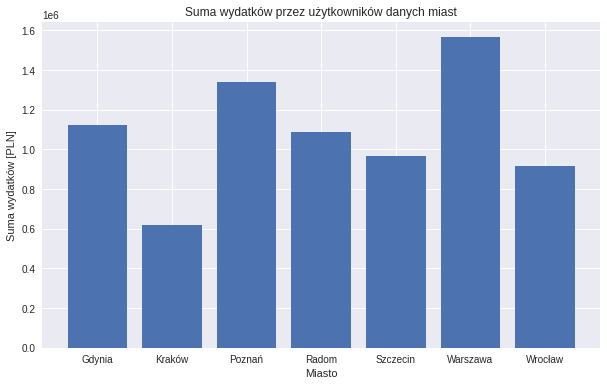

In [205]:
plt.bar(np.sort(main_df['city'].unique()), main_df.groupby(main_df['city'])['price'].agg('sum'))
plt.title('Suma wydatków przez użytkowników danych miast')
plt.xlabel('Miasto')
plt.ylabel('Suma wydatków [PLN]')

## Wydatki użytkowników pochodzących z danych miast w każdym tygodniu

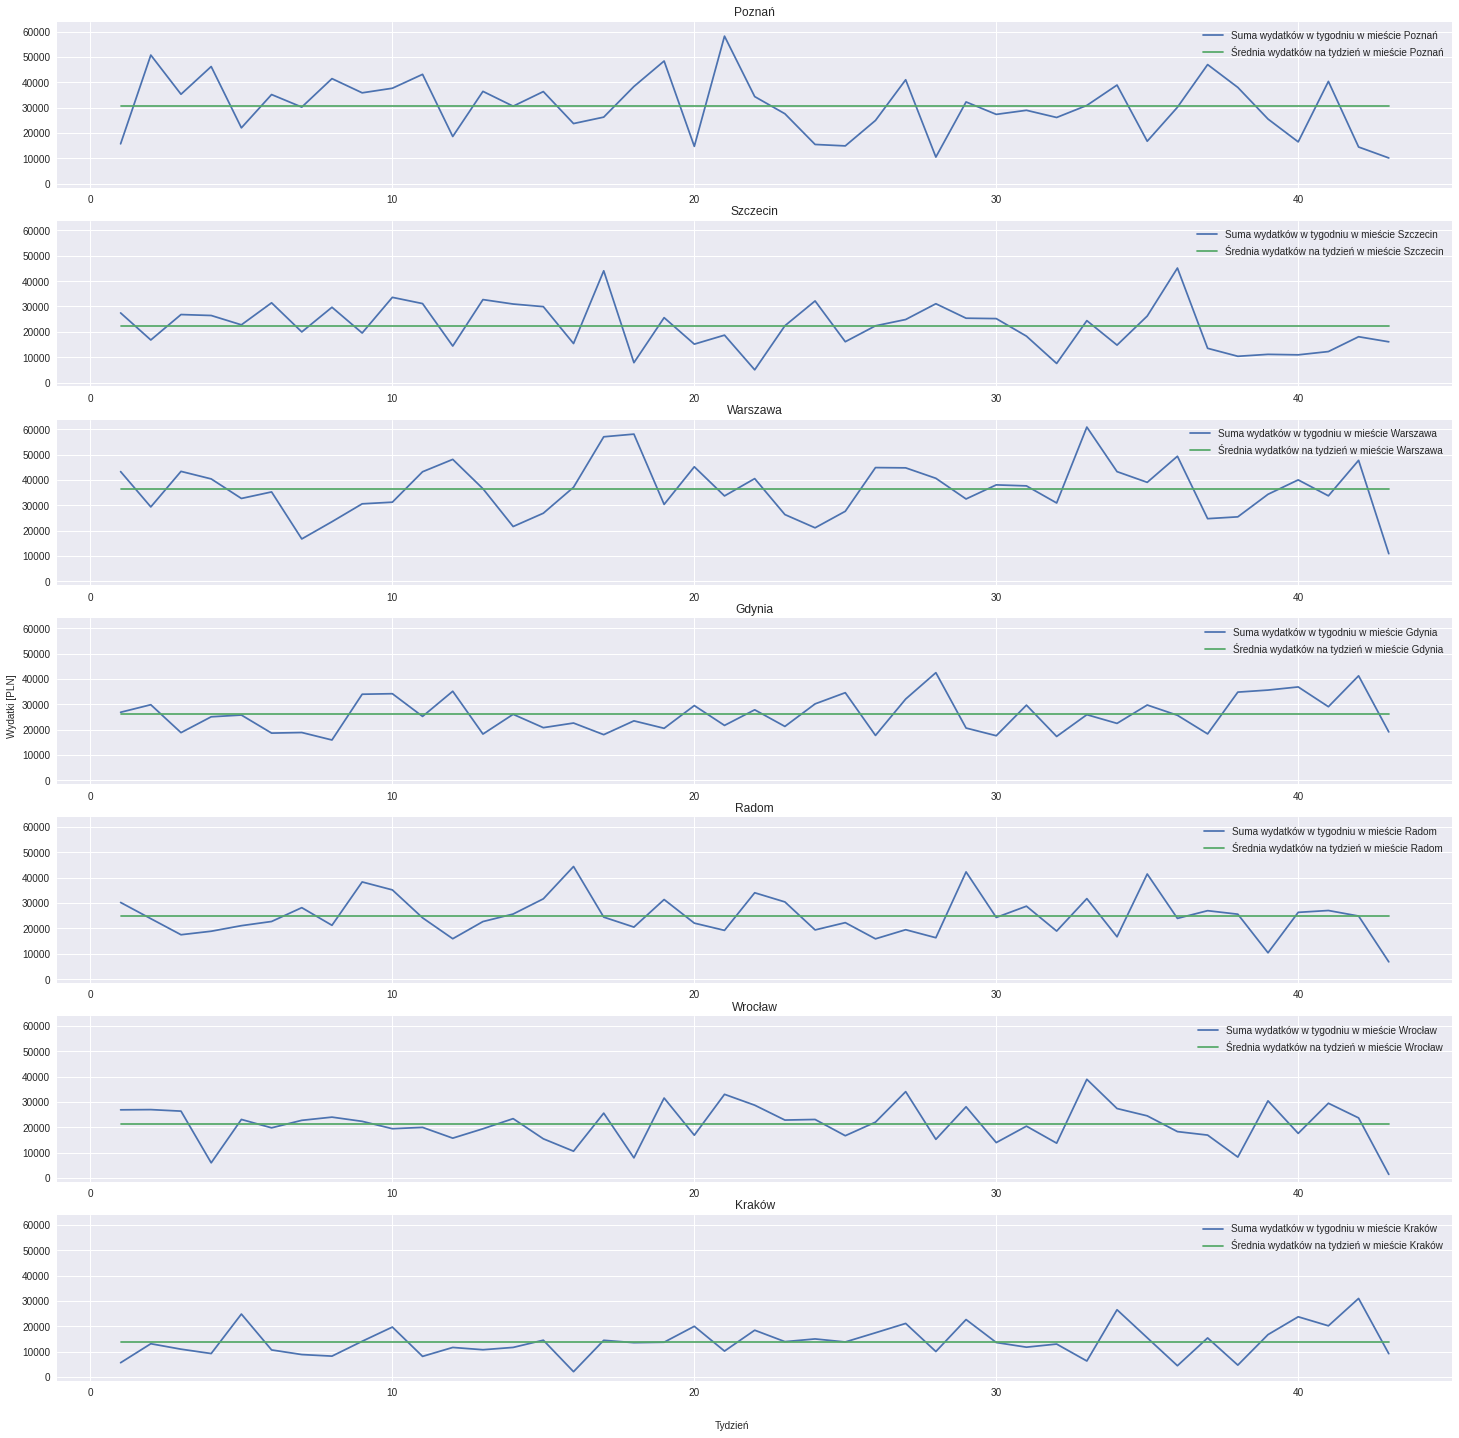

In [206]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(25,25), sharex='row', sharey='col')

fig.text(0.5, 0.1, 'Tydzień', ha='center', va='center')
fig.text(0.1, 0.5, 'Wydatki [PLN]', ha='center', va='center', rotation='vertical')
for i, city in enumerate(main_df['city'].unique()):
    ax[i].plot(
        main_df.loc[(main_df['city'] == city) & (main_df['session_start'].dt.isocalendar().week != 53)].groupby(main_df.loc[main_df['city'] == city]['session_start'].dt.isocalendar().week).aggregate({'price': 'sum'}), label=f"Suma wydatków w tygodniu w mieście {city}"
    )
    mean_by_week = main_df.loc[(main_df['city'] == city) & (main_df['session_start'].dt.isocalendar().week != 53)]['price'].sum() / 43
    ax[i].plot(np.arange(1, 44), [mean_by_week]*43, label=f"Średnia wydatków na tydzień w mieście {city}")
    ax[i].set_title(city)
    ax[i].legend()